# Prediction of Active Enhancers with CNN

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple
import os
import compress_json
from tqdm.auto import tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from plot_keras_history import plot_history
from barplots import barplots

Using TensorFlow backend.


In [2]:
models = []

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

perceptron = Sequential([
    Input(shape=(200, 4)),
    Flatten(),
    Dense(1, activation="sigmoid")
], "Perceptron")

perceptron.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

models.append(perceptron)

In [4]:
mlp = Sequential([
    Input(shape=(200, 4)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], "MLP")

mlp.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

models.append(mlp)

In [5]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation

ffnn = Sequential([
    Input(shape=(200, 4)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "FFNN")

ffnn.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

ffnn.summary()
models.append(ffnn)

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080   

In [6]:
from tensorflow.keras.layers import Conv2D, Reshape

cnn = Sequential([
    Input(shape=(200, 4)),
    Reshape((200, 4, 1)),
    Conv2D(64, (10, 2), activation="relu", padding="same"),
    Conv2D(64, (10, 2), activation="relu", padding="same"),
    Dropout(0.3),
    Conv2D(32, (10, 1), activation="relu", padding="same"),
    Conv2D(32, (10, 1), activation="relu", padding="same"),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "CNN")

cnn.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

cnn.summary()
models.append(cnn)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 200, 4, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 4, 64)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 4, 64)        81984     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 4, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 4, 32)        20512     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 4, 32)        10272     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 4, 32)        0       

In [7]:
from tensorflow.keras.layers import LSTM

cudnn_lstm = dict(
    activation="tanh",
    recurrent_activation="sigmoid",
    recurrent_dropout=0,
    unroll=False,
    use_bias=True
)

lstm = Sequential([
    Input(shape=(200, 4)),
    LSTM(256, **cudnn_lstm),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
], "LSTM")

lstm.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

lstm.summary()
models.append(lstm)

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               267264    
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17     

In [8]:
from epigenomic_dataset import load_epigenomes

cell_line = "GM12878"
window_size = 200

epigenomes, labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)

epigenomes = epigenomes.droplevel(1, axis=1) 
labels = labels.values.ravel()

bed = epigenomes.reset_index()[epigenomes.index.names]

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 3
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)

In [10]:
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence
from tensorflow.keras.utils import Sequence

genome = Genome("hg19")

def get_holdout(train:np.ndarray, test:np.ndarray, bed:pd.DataFrame, labels:np.ndarray, genome:genome, batch_size=1024)->Tuple[Sequence, Sequence]:
    return (
        MixedSequence(
            x= BedSequence(genome, bed.iloc[train], batch_size=batch_size),
            y=labels[train],
            batch_size=batch_size
        ),
        MixedSequence(
            x= BedSequence(genome, bed.iloc[test], batch_size=batch_size),
            y=labels[test],
            batch_size=batch_size
        )
    )

In [11]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [12]:
if os.path.exists("sequence.json"):
    results = compress_json.local_load("sequence.json")
else:
    results = []

for i, (train_index, test_index) in tqdm(enumerate(holdouts.split(bed, labels)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
    train, test = get_holdout(train_index, test_index, bed, labels, genome)
    for model in tqdm(models, total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        if precomputed(results, model.name, i):
            continue
        history = model.fit(
            train,
            steps_per_epoch=train.steps_per_epoch,
            validation_data=test,
            validation_steps=test.steps_per_epoch,
            epochs=1000,
            shuffle=True,
            verbose=False,
            callbacks=[
                EarlyStopping(monitor="val_loss", mode="min", patience=50),
            ]
        ).history
        scores = pd.DataFrame(history).iloc[-1].to_dict()
        results.append({
            "model":model.name,
            "run_type":"train",
            "holdout":i,
            **{
                key:value
                for key, value in scores.items()
                if not key.startswith("val_")
            }
        })
        results.append({
            "model":model.name,
            "run_type":"test",
            "holdout":i,
            **{
                key[4:]:value
                for key, value in scores.items()
                if key.startswith("val_")
            }
        })
        compress_json.local_dump(results, "sequence.json")

In [13]:
df = pd.DataFrame(results).drop(columns="holdout")

In [14]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal",
    path='barplots/sequence/{feature}.png',
)

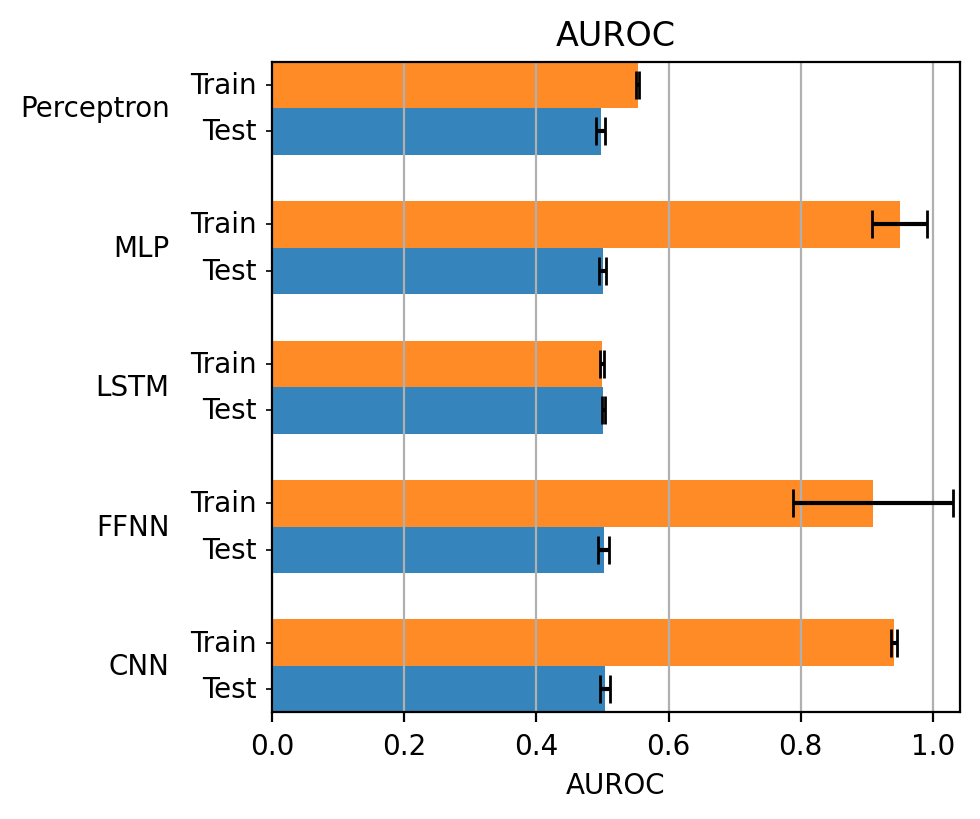

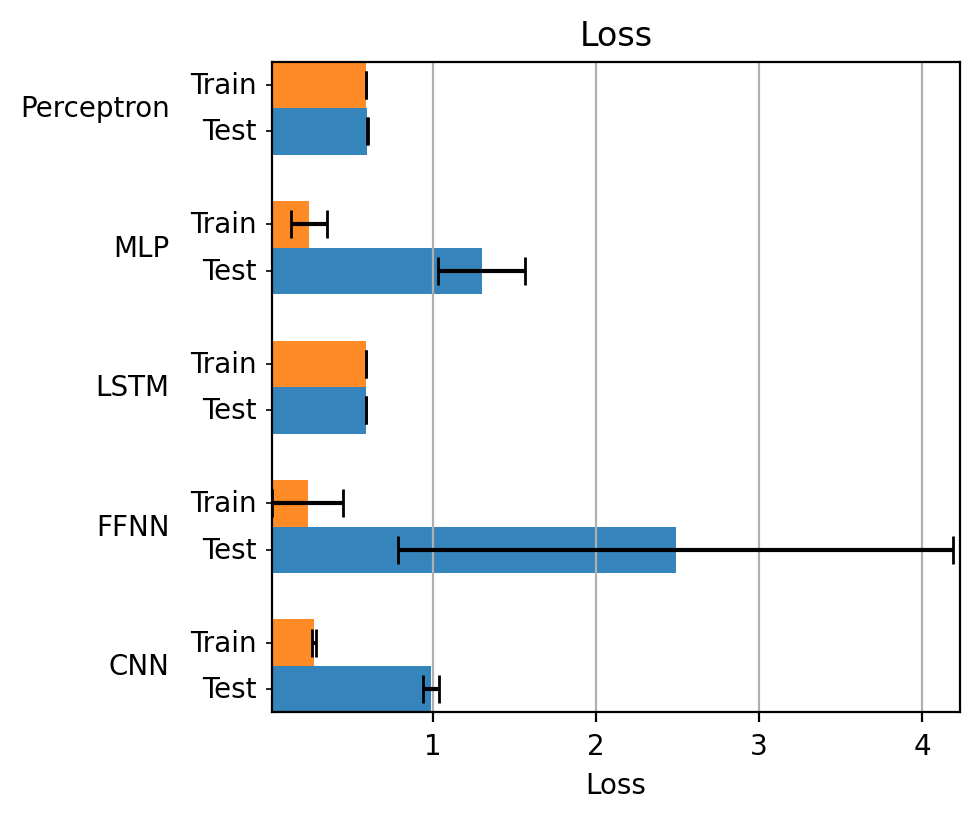

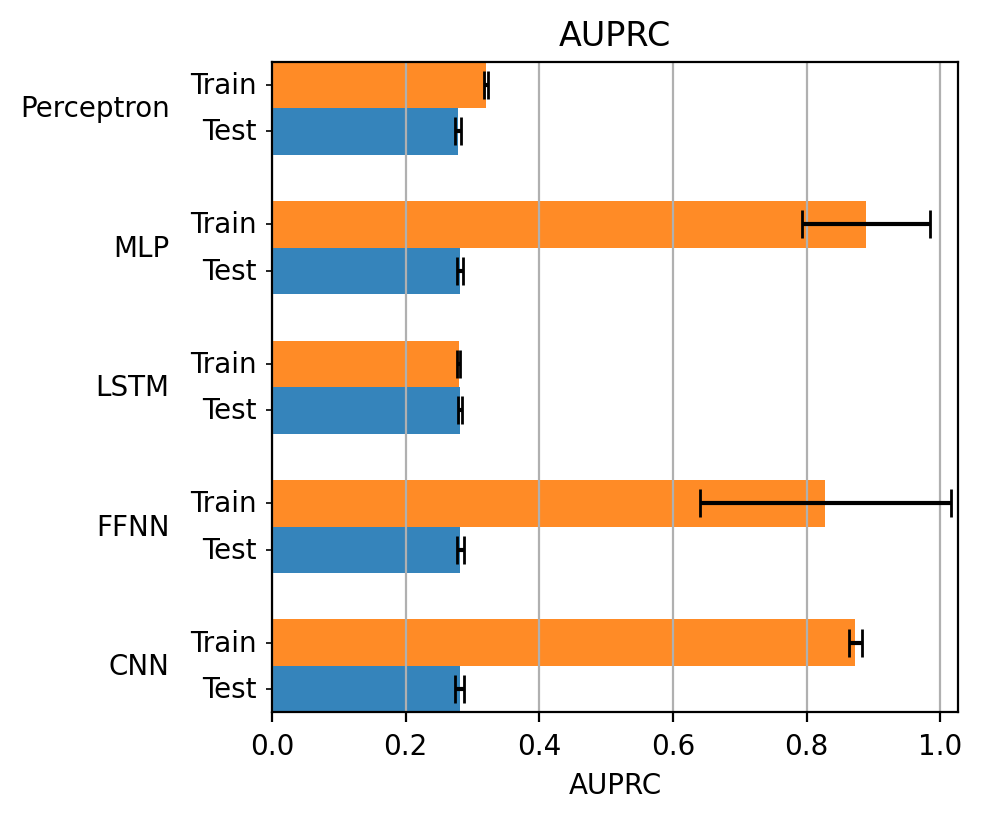

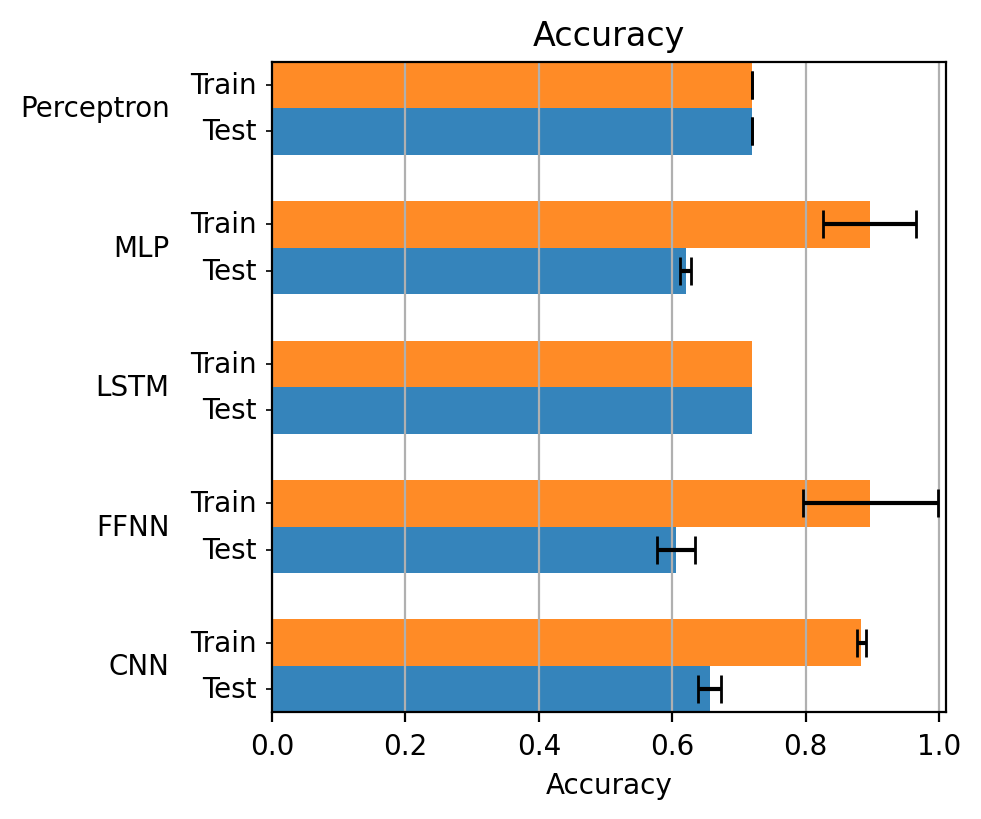

In [15]:
from PIL import Image
from glob import glob

for x in glob("barplots/sequence/*.png"):
    display(Image.open(x))